In [1]:
import torch
from torch.nn import ConvTranspose2d, Conv2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch import Tensor

In [2]:
import os
import random
import shutil

# Path to your image and mask folders
image_folder = "Driving_GTA_Dataset/IMAGES"
mask_folder = "Driving_GTA_Dataset/LABELS"
train_data_dir = "Driving_GTA_Dataset/train/train"
val_data_dir = "Driving_GTA_Dataset/val/val"
train_data_dir_mask = "Driving_GTA_Dataset/train/train_label"
val_data_dir_mask = "Driving_GTA_Dataset/val/val_label"

image_files = os.listdir(image_folder)

random.seed(42)

random.shuffle(image_files)

split_ratio = 0.8
split_idx = int(len(image_files) * split_ratio)

train_image_files = image_files[:split_idx]
val_image_files = image_files[split_idx:]

os.makedirs(os.path.join(train_data_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(val_data_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(train_data_dir_mask, "masks"), exist_ok=True)
os.makedirs(os.path.join(val_data_dir_mask, "masks"), exist_ok=True)

for filename in train_image_files:
    img_src = os.path.join(image_folder, filename)
    mask_src = os.path.join(mask_folder, filename)  # Assume mask filenames match image filenames
    shutil.move(img_src, os.path.join(train_data_dir, filename))
    shutil.move(mask_src, os.path.join(train_data_dir_mask, filename))

for filename in val_image_files:
    img_src = os.path.join(image_folder, filename)
    mask_src = os.path.join(mask_folder, filename)  # Assume mask filenames match image filenames
    shutil.move(img_src, os.path.join(val_data_dir, filename))
    shutil.move(mask_src, os.path.join(val_data_dir_mask, filename))

In [3]:
# pip install tensorflow

In [4]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
# import tensorflow as tf

In [5]:
# Train = {'img' : [],
#            'mask' : []
#           }

# Validation = {'img' : [],
#            'mask' : []
#           }

# def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
#     imgNames = os.listdir(imgPath)
#     maskNames = []
    
#     for mem in imgNames:
#         maskNames.append(re.sub('.png', '.png', mem))
    
#     imgAddr = imgPath + '/'
#     maskAddr = maskPath + '/'
    
#     for i in range (len(imgNames)):
#         img = plt.imread(imgAddr + imgNames[i])
#         mask = plt.imread(maskAddr + maskNames[i])
        
#         img = cv2.resize(img, (shape, shape)) 
#         mask = cv2.resize(mask, (shape, shape))
        
#         frameObj['img'].append(img)
#         frameObj['mask'].append(mask)
        
#     return frameObj

In [6]:
# Train = LoadData( Train, imgPath = 'Driving_GTA_Dataset/train/train', maskPath = 'Driving_GTA_Dataset/train/train_label', shape = 256)

In [7]:
# Validation  = LoadData( Validation, imgPath = 'Driving_GTA_Dataset/val/val', maskPath = 'Driving_GTA_Dataset/val/val_label', shape = 256)

In [8]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

class CustomSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=False, transform_img=None, transform_mask=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.transform_img = transform_img
        self.transform_mask = transform_mask

        self.img_names = os.listdir(img_dir)
        self.mask_names = os.listdir(mask_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        mask_name = self.mask_names[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_name))
        mask = cv2.imread(os.path.join(self.mask_dir, mask_name))
        
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        if img is None or mask is None:
            return self.__getitem__((idx + 1) % len(self)) 

        if self.transform:
            img = self.transform_img(img)
            mask = self.transform_mask(mask)

        return img, mask

# Define the transformation for images and masks
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming 3-channel RGB images
])

transform_mask = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # Assuming 3-channel RGB images
])

train_img_dir = 'Driving_GTA_Dataset/train/train/'
train_mask_dir = 'Driving_GTA_Dataset/train/train_label/'
val_img_dir = 'Driving_GTA_Dataset/val/val/'
val_mask_dir = 'Driving_GTA_Dataset/val/val_label/'

# Create instances of CustomSegmentationDataset for train and validation
train_dataset = CustomSegmentationDataset(img_dir=train_img_dir, mask_dir=train_mask_dir, transform=True, transform_img=transform_img, transform_mask=transform_mask)
val_dataset = CustomSegmentationDataset(img_dir=val_img_dir, mask_dir=val_mask_dir, transform=True, transform_img=transform_img, transform_mask=transform_mask)

# Define batch size
batch_size = 64
num_workers= 4

# Create data loaders for train and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers, pin_memory=True)

In [9]:
# train_dataset.__getitem__(6)

In [10]:
len(val_dataset)

4996

In [11]:
len(train_dataset)

19973

In [ ]:
import matplotlib.pyplot as plt

batch_images, batch_masks = next(iter(train_loader))

plt.subplot(1, 2, 1)
plt.imshow(batch_images[1].permute(1, 2, 0))
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(batch_masks[1][0])
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
#     Downscaling with maxpool then double conv

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
#     Upscaling then double conv

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]   #diff in height
        diffX = x2.size()[3] - x1.size()[3]   #diff in width
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [15]:
import torch.optim as optim
in_channels = 3 
out_channels = 3  
unet_model = UNet(in_channels, out_channels)

In [16]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.RMSprop(unet_model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.999, foreach=True)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)

In [17]:
from tqdm import tqdm
from time import sleep

In [18]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    assert input.size() == target.size()
    assert input.dim() == 4 or not reduce_batch_first  # Change dim() to 4 for 4D tensors

    sum_dim = (-2, -1) if input.dim() == 3 or not reduce_batch_first else (-2, -1, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    return dice_coeff(input, target, reduce_batch_first, epsilon)  # No need to flatten here


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [19]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model.to(device)

for epoch in range(num_epochs):
    unet_model.train()  
    running_loss = 0.0

    for inputs, masks in tqdm(train_loader):
        inputs = inputs.to(device)
        masks = masks.to(device)
    
        optimizer.zero_grad()

        outputs = unet_model(inputs)
        
        ce_loss = criterion(outputs, masks)
        
        if unet_model.n_classes == 1:
            dice_loss_value = dice_loss(F.sigmoid(outputs), masks.float(), multiclass=False)
        else:
            masks_argmax = masks.argmax(dim=1, keepdim=True)
            masks_one_hot = F.one_hot(masks_argmax.squeeze(1), unet_model.n_classes).permute(0, 3, 1, 2).float()

            dice_loss_value = dice_loss(F.softmax(outputs, dim=1), masks_one_hot, multiclass=True)    
        loss = ce_loss + dice_loss_value
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

unet_model.eval()  
running_loss = 0.0

with torch.no_grad():
    for inputs, masks in val_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)

        outputs = unet_model(inputs)
        loss = criterion(outputs, masks)

        running_loss += loss.item() * inputs.size(0)

val_loss = running_loss / len(val_loader.dataset)

print(f'Validation Loss: {val_loss:.4f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [1/20], Train Loss: 1.7679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [2/20], Train Loss: 1.7373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [3/20], Train Loss: 1.7254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [4/20], Train Loss: 1.7109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [5/20], Train Loss: 1.7010


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [6/20], Train Loss: 1.6938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [7/20], Train Loss: 1.6890


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:19<00:00,  1.21s/it]


Epoch [8/20], Train Loss: 1.6838


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [9/20], Train Loss: 1.6799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [10/20], Train Loss: 1.6772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [11/20], Train Loss: 1.6734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [12/20], Train Loss: 1.6706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [13/20], Train Loss: 1.6691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [14/20], Train Loss: 1.6674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.20s/it]


Epoch [15/20], Train Loss: 1.6662


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch [16/20], Train Loss: 1.6641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [17/20], Train Loss: 1.6622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [18/20], Train Loss: 1.6609


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]


Epoch [19/20], Train Loss: 1.6588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [06:17<00:00,  1.21s/it]

Epoch [20/20], Train Loss: 1.6570


Validation Loss: 1.2619


In [25]:
# import matplotlib.pyplot as plt

# plt.plot(train_losses, label='train_loss')
# plt.plot(val_losses, label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [26]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
def visualize_images(inputs, outputs, masks, num_images=5):
#     outputs = torch.tensor(cv2.cvtColor(np.array(outputs), cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    images = torch.cat([inputs[:num_images], outputs[:num_images], masks[:num_images]], dim=0)
    grid = make_grid(images, nrow=num_images)

    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [27]:
unet_model.eval()

batch_inputs, batch_masks = next(iter(val_loader))
batch_inputs = batch_inputs.to(device)

with torch.no_grad():
    batch_outputs = unet_model(batch_inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


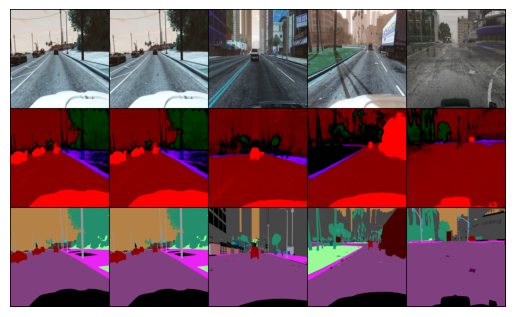

In [28]:
visualize_images(batch_inputs.cpu(), batch_outputs.cpu(), batch_masks.cpu())

In [29]:
import torch
torch.save(unet_model.state_dict(), 'unet_segmentation1.pt')